In [1]:
import csv
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt

In [2]:
def spCoef(n):
    s = [0]*(n+1)
    sig = [0]*(n+1)
    tau = [0]*(n+1)
    sig[1]=0
    tau[1]=0
    for i in range(1,n-1):
        Him1=x[i]-x[i-1]
        Hi=x[i+1]-x[i]
        temp=(Him1/Hi)*(sig[i]+2)+2
        sig[i+1]=-1/temp
        d=6*((y[i+1]-y[i])/Hi - (y[i]-y[i-1])/Him1)/Hi
        tau[i+1]=(d-Him1*tau[i]/Hi)/temp
    s[1]=0
    s[n]=0
    for i in range(1,n-1):
        ib=n-i
        s[ib]=sig[ib+1]*s[ib+1]+tau[ib+1]
    return s

In [3]:
def spline(n,alpha,s):
    for i in range(1,n+1):
        if (alpha<=x[i]):
            break;
    i=i-1
    a=x[i+1]-alpha
    b=alpha-x[i]
    hi=x[i+1]-x[i]
    beta=a*s[i]*(a*a/hi-hi)/6+b*s[i+1]*(b*b/hi-hi)/6+(a*y[i]+b*y[i+1])/hi
    return beta

In [4]:
def readCsvFile(filePath):
    with open(filePath,'r') as f:
        reader = csv.reader(f)
        data = list(reader)
    for line in data:
        x.append(float(line[0]))
        y.append(float(line[1]))
    print("X:")
    print(x)
    print("Y:")
    print(y)

In [5]:
def sortPoints():
    for i in range(1,n):
        tmin=x[i]
        imin=i
        for j in range(i+1,n-1):
            if tmin>x[j]:
                tmin=x[j]
                imin=j
        if imin!=i:
            x[imin]=x[i]
            x[i]=tmin
            tmin=y[imin]
            y[imin]=y[i]
            y[i]=tmin

In [6]:
def generateSpline(n):
    # sort points respect independent variable
    sortPoints()
    # get second derivatives coeficients
    s = spCoef(n)
    xini = x[0]
    xfin = x[len(x)-1]
    x_new = np.linspace(xini, xfin, 201)
    y_new = []
    for xn in x_new:
        y_ip = spline(n,xn,s)
        y_new.append(y_ip)
    plt.scatter(x, y)
    plt.plot(x_new, y_new)
    plt.grid()
    plt.show()

## Create spline from csv file

A partir de la curva sigmoide definidia por la función
$$\frac{1}{1+e^{-x}}$$
se toman 10 puntos a lo largo del dominio $$x \in [-8,10]$$  y se calculan los Splines que interpolan dicha curva para interpolar 201 puntos en el mismo dominio. Se presenta un gráfico para evaluar cualitativamente el resultado.

X:
[-8.0, -6.0, -4.0, -2.0, 0.0, 2.0, 4.0, 6.0, 8.0, 10.0]
Y:
[0.0003, 0.0024, 0.0179, 0.1192, 0.5, 0.8807, 0.982, 0.9975, 0.9996, 0.9999]


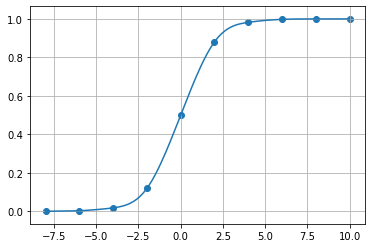

In [7]:
# data variables
x=[]
y=[]
# read csv file
readCsvFile("sigmoidValues.csv")
# get x length
n = len(x)
if (n>3):
    generateSpline(n)
else:
    print("Error: El algoritmo requiere de al menos 4 puntos coordenados")

## another aproach

In [2]:
def cubic_interp1d(x0, x, y):
    """
    Interpolate a 1-D function using cubic splines.
      x0 : a float or an 1d-array
      x : (N,) array_like
          A 1-D array of real/complex values.
      y : (N,) array_like
          A 1-D array of real values. The length of y along the
          interpolation axis must be equal to the length of x.

    Implement a trick to generate at first step the cholesky matrice L of
    the tridiagonal matrice A (thus L is a bidiagonal matrice that
    can be solved in two distinct loops).

    additional ref: www.math.uh.edu/~jingqiu/math4364/spline.pdf 
    """
    x = np.asfarray(x)
    y = np.asfarray(y)

    # remove non finite values
    # indexes = np.isfinite(x)
    # x = x[indexes]
    # y = y[indexes]

    # check if sorted
    if np.any(np.diff(x) < 0):
        indexes = np.argsort(x)
        x = x[indexes]
        y = y[indexes]

    size = len(x)

    xdiff = np.diff(x)
    ydiff = np.diff(y)

    # allocate buffer matrices
    Li = np.empty(size)
    Li_1 = np.empty(size-1)
    z = np.empty(size)

    # fill diagonals Li and Li-1 and solve [L][y] = [B]
    Li[0] = sqrt(2*xdiff[0])
    Li_1[0] = 0.0
    B0 = 0.0 # natural boundary
    z[0] = B0 / Li[0]

    for i in range(1, size-1, 1):
        Li_1[i] = xdiff[i-1] / Li[i-1]
        Li[i] = sqrt(2*(xdiff[i-1]+xdiff[i]) - Li_1[i-1] * Li_1[i-1])
        Bi = 6*(ydiff[i]/xdiff[i] - ydiff[i-1]/xdiff[i-1])
        z[i] = (Bi - Li_1[i-1]*z[i-1])/Li[i]

    i = size - 1
    Li_1[i-1] = xdiff[-1] / Li[i-1]
    Li[i] = sqrt(2*xdiff[-1] - Li_1[i-1] * Li_1[i-1])
    Bi = 0.0 # natural boundary
    z[i] = (Bi - Li_1[i-1]*z[i-1])/Li[i]

    # solve [L.T][x] = [y]
    i = size-1
    z[i] = z[i] / Li[i]
    for i in range(size-2, -1, -1):
        z[i] = (z[i] - Li_1[i-1]*z[i+1])/Li[i]

    # find index
    index = x.searchsorted(x0)
    np.clip(index, 1, size-1, index)

    xi1, xi0 = x[index], x[index-1]
    yi1, yi0 = y[index], y[index-1]
    zi1, zi0 = z[index], z[index-1]
    hi1 = xi1 - xi0

    # calculate cubic
    f0 = zi0/(6*hi1)*(xi1-x0)**3 + \
         zi1/(6*hi1)*(x0-xi0)**3 + \
         (yi1/hi1 - zi1*hi1/6)*(x0-xi0) + \
         (yi0/hi1 - zi0*hi1/6)*(xi1-x0)
    return f0


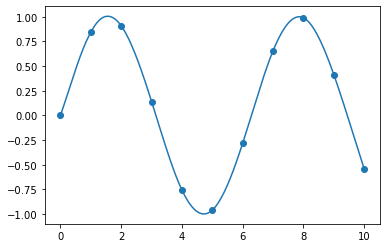

In [8]:
x = np.linspace(0, 10, 11)
y = np.sin(x)
plt.scatter(x, y)

x_new = np.linspace(0, 10, 201)
plt.plot(x_new, cubic_interp1d(x_new, x, y))

plt.show()